In [101]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf
np.random.seed(1)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# 5.4 Exercises

## Conceptual

**1.** Using basic statistical properties of the variance, as well as single- variable calculus, derive (5.6). In other words, prove that α given by (5.6) does indeed minimize $Var(\alpha X + (1 - \alpha)Y)$.

We want to minimize:
$$
Var(\alpha X + (1 - \alpha)Y)
\\
= Var(\alpha X) + Var((1 - \alpha) Y) + 2 Cov(\alpha X, (1 - \alpha) Y)
\\
= \alpha^2 Var(X) + (1 - \alpha)^2 Var(Y) + 2 \alpha (1 - \alpha) Cov(X, Y)
\\
= \sigma_X^2 \alpha^2 + \sigma_Y^2 (1 - \alpha)^2 + 2 \sigma_{XY} (-\alpha^2 +
\alpha)
$$

Take the first derivative to find critical points:
$$
0 = \frac {d} {d\alpha} f(\alpha)
\\
0 = 2 \sigma_X^2 \alpha + 2 \sigma_Y^2 (1 - \alpha) (-1) + 2 \sigma_{XY}
(-2 \alpha + 1)
\\
0 = \sigma_X^2 \alpha + \sigma_Y^2 (\alpha - 1) + \sigma_{XY} (-2 \alpha + 1)
\\
0 = (\sigma_X^2 + \sigma_Y^2 - 2 \sigma_{XY}) \alpha - \sigma_Y^2 + \sigma_{XY}
\\
\alpha = \frac {\sigma_Y^2 - \sigma_{XY}}
               {\sigma_X^2 + \sigma_Y^2 - 2 \sigma_{XY}}
$$

**2.** We will now derive the probability that a given observation is part of a bootstrap sample. Suppose that we obtain a bootstrap sample from a set of n observations.

**(a)** What is the probability that the first bootstrap observation is not the jth observation from the original sample? Justify your answer.

$$
\Pr ({x_1} \ne {x_j}|{x_1}) = \frac{1}{n}\sum\nolimits_{j = 1}^n {I({x_1} \ne {x_j})}  = \frac{{n - 1}}{n}
$$

**(b)** What is the probability that the second bootstrap observation is not the jth observation from the original sample?

>Same as **(a)**.

**(c)** Argue that the probability that the jth observation is not in the bootstrap sample is $(1 - 1/n)^n$.

Bootstrap is sample with replacement, so each observation in the bootstrap sample has the same 1/n (independent) chance of equaling the jth observation. Applying the product rule for a total of n observations gives us $(1 - 1/n)^n$.

**(d),(e),(f)** When n = 5, 100, and 10, 000, what is the probability that the jth observation is in the bootstrap sample?

In [26]:
[1-((1-(1/n))**n) for n in [5, 100, 10000]]

[0.6723199999999999, 0.6339676587267709, 0.6321389535670295]

**(g)** Create a plot that displays, for each integer value of n from 1 to 100,000, the probability that the jth observation is in the bootstrap sample. Comment on what you observe.

>Very quickly reaches the ~63% probability and stays there.

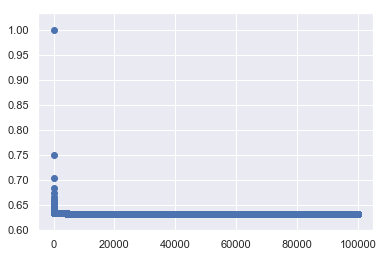

In [73]:
x = np.arange(1, 100001)
y = 1-((1-(1/x))**x)
plt.scatter(x,y)
plt.show()

**(h)** We will now investigate numerically the probability that a boot- strap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time we record whether or not the fourth observation is contained in the bootstrap sample.

> returns ~63%. Very close to our theoretical probablility.

In [87]:
x = np.random.randint(1, 101, (100, 10000))
np.any(x == 4, axis=0).mean()

0.6345

**3.** We now review k-fold cross-validation.
**(a)** Explain how k-fold cross-validation is implemented.
**(b)** What are the advantages and disadvantages of k-fold cross-validation relative to:
i. The validation set approach? ii. LOOCV?

>In k-fold CV you randomly divide the set of observation into k groups, or folds, of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining k-1 folds. The error rate is then computed on the observation in the held-out fold. This procedure is repeated k times; each time a different group of observations (a fold) is treated as a validation set. The process results in k estimates of the test error and k-fold CV estimate is computed by averaging these values.
One advantage over LOOCV is computational, bc LOOCV requires fitting the method n times. This can be expensive if n is large. If k is 5 or 10 you only have to fit the method 5 or 10 times. Additionally k-fold has lower variance and higher bias than LOOCV. Therefore k-fold often give more accurate estimates of the test error than LOOCV and this has to do with the bias-variance trade-off.
The advantages of k-fold over the validation set approach include the fact that the validation set approach can produce highly variable test error rates.  This can happen depending on precisely which obs are included in the training set and which obs are in the validation set. K-fold addresses this by having k validation sets and training sets. Additionally, since statistical methods tend to performs worse when trained on fewer obs, the validation set error rate may tend to overestimated teh test error rate. K-fold allows for k training sets.

**4.** Suppose that we use some statistical learning method to make a prediction for the response Y for a particular value of the predictor X. Carefully describe how we might estimate the standard deviation of our prediction.

>We can bootstrap estimates of Y and use those estimates to calculate standard deviation. Through enough bootstrap estimates you could approximate a mean. From there you could calculate a standard deviation.

## Applied

**5.** In Chapter 4, we used logistic regression to predict the probability of `default` using `income` and `balance` on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

**(a)** Fit a logistic regression model that uses `income` and `balance` to predict `default`.

**(b)** Using the validation set approach, estimate the test error of this model.

In [95]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv', index_col=0).dropna()

In [160]:
df['default01'] = np.where(df['default'] == 'Yes', 1, 0)
df['student01'] = np.where(df['student'] == 'Yes', 1, 0)
print("Dataframe shape: " + str(df.shape))
df.head()

Dataframe shape: (10000, 6)


,default,student,balance,income,default01,student01
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0
4,No,No,529.250605,35704.493935,0,0
5,No,No,785.655883,38463.495879,0,0


In [161]:
X = df[['income','balance']].values
y = df['default01'].values
print(X.shape)
print(y.shape)

(10000, 2)
(10000,)


In [166]:
# split data. for this example will we use 50/50 split

# to get different test/train samples adjust 'random_state'

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.5, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5000, 3)
(5000, 3)
(5000,)
(5000,)


In [148]:
# Logistic regression model
# sklearn does regularization by default so you have to have values for 'C' and 'tol'
#  'tol' is 'tolerance for stopping criteria' (input low value)
#  'C' is 'invers of regularization strength' (input high integer)

clf = LogisticRegression(C=1e9, tol=.0000001)
clf.fit(X_train, y_train)

print(clf.intercept_)
print(clf.coef_)

[-11.61855083]
[[1.62553817e-05 5.83500730e-03]]


In [137]:
conf_matrix = pd.crosstab(clf.predict(X_test), y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL

print("Test accuracy: " + str(accuracy))
print("Test error rate: " + str(error_rate))
conf_matrix

Test accuracy: 0.975
Test error rate: 0.025


Actual,0,1,All
Predicted,,,
0,4817,101,4918
1,24,58,82
All,4841,159,5000


**(c)** Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

>Similar error rates.

In [158]:
# build 3 models with different test/train samples

clf = LogisticRegression(C=1e9, tol=.0000001)

for i in range(2,5):
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=i)
    clf.fit(X_train, y_train)
    conf_matrix = pd.crosstab(clf.predict(X_test), y_test, rownames=['Predicted'],
                colnames=['Actual'], margins=True)
    TN = conf_matrix.iloc[0][0]
    TP = conf_matrix.iloc[1][1]
    FN = conf_matrix.iloc[0][1]
    FP = conf_matrix.iloc[1][0]
    ALL = conf_matrix.iloc[2][2]
    accuracy = (TP+TN)/ALL
    error_rate = (FP+FN)/ALL
    print(conf_matrix)
    print("Test error rate: " + str(error_rate) + "\n")

Actual        0    1   All
Predicted                 
0          4824  102  4926
1            22   52    74
All        4846  154  5000
Test error rate: 0.0248

Actual        0    1   All
Predicted                 
0          4817  110  4927
1            14   59    73
All        4831  169  5000
Test error rate: 0.0248

Actual        0    1   All
Predicted                 
0          4818  100  4918
1            19   63    82
All        4837  163  5000
Test error rate: 0.0238



**(d)** Now consider a logistic regression model that predicts the probability of `default` using `income`, `balance`, and a dummy variable for `student`. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

>Pretty much same test error rate.

In [164]:
X = df[['income','balance','student01']].values
y = df['default01'].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=i)

clf = LogisticRegression(C=1e9, tol=.0000001)
clf.fit(X_train, y_train)

print(clf.intercept_)
print(clf.coef_)
print((clf.predict(X_test)==y_test).mean())

[-10.4849266]
[[ 2.84398868e-06  5.59945216e-03 -7.92877396e-01]]
0.9756


**6.** We continue to consider the use of a logistic regression model to predict the probability of `default` using `income` and `balance` on the `Default` data set. In particular, we will now compute estimates for the standard errors of the `income` and `balance` logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the glm() function. Do not forget to set a random seed before beginning your analysis.

**(a)** Using the summary() and glm() functions, determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.

**(b),(c),(d)**

>The standard errors obtained from logistic regression and bootstrap method are very similar.

In [173]:
X = df[['income','balance']].values
y = df['default01'].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=i)

clf = LogisticRegression(C=1e9, tol=.0000001)
clf.fit(X_train, y_train)

print(clf.intercept_)
print(clf.coef_)

[-11.30047434]
[[2.46453648e-05 5.48440274e-03]]


In [177]:
# statsmodel
glm = smf.logit('default01 ~ income+balance', data=df).fit()
glm.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              default01   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Tue, 30 Oct 2018   Pseudo R-squ.:                  0.4594
Time:                        14:09:24   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
                                        LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [246]:
# bootstrap models

df_params = pd.DataFrame(columns=['Intercept', 'balance', 'income'])
for i in range(100):
    default_sample = df.sample(len(df), replace=True)
    result_sample = smf.logit(formula='default01 ~ balance + income', data=default_sample).fit(disp=0)
    df_params = df_params.append(result_sample.params, ignore_index=True)

In [247]:
print("Standard errors from bootstrap:")
print(df_params.std(axis=0))

Standard errors from bootstrap:
Intercept    0.440460
balance      0.000252
income       0.000005
dtype: float64


In [249]:
print("Standard errors from model:")
print(glm.bse)

Standard errors from model:
Intercept    0.434772
income       0.000005
balance      0.000227
dtype: float64


**7.** In Sections 5.3.2 and 5.3.3, we saw that the cv.glm() function can be used in order to compute the LOOCV test error estimate. Alternatively, one could compute those quantities using just the glm() and predict.glm() functions, and a for loop. You will now take this approach in order to compute the LOOCV error for a simple logistic regression model on the Weekly data set. Recall that in the context of classification problems, the LOOCV error is given in (5.4).

**(a)** Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2`.

In [253]:
df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/Weekly.csv")

In [254]:
# convert 'Direction' from 'Yes/No' to 0/1. For ease in modeling.
df['Direction01'] = np.where(df['Direction'] == 'Up', 1, 0)
print("Shape of dataframe: " + str(df.shape))
df.head()

Shape of dataframe: (1089, 10)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction01
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1


In [255]:
X = df[['Lag1','Lag2']]
y = df['Direction01']

In [256]:
clf = LogisticRegression(C=1e9, tol=.0000001)
clf.fit(X,y)

print(clf.intercept_)
print(clf.coef_)

[0.22122405]
[[-0.03872222  0.0602483 ]]


**(b)** Fit a logistic regression model that predicts `Direction` using `Lag1` and `Lag2` using all but the first observation.

In [260]:
clf.fit(X.iloc[1:],y[1:])

print(clf.intercept_)
print(clf.coef_)

[0.22324305]
[[-0.03843317  0.06084763]]


**(c)** Use the model from (b) to predict the direction of the first observation.

>Misclassified.

In [266]:
print("Predicted probability 0/1:")
print(clf.predict_proba(X.iloc[:1]))
print("Predicted outcome 0=down, 1=up:")
print(clf.predict(X.iloc[:1]))
print("Actual outcome:")
print(y[0])

Predicted probability 0/1:
[[0.42860768 0.57139232]]
Predicted outcome 0=down, 1=up:
[1]
Actual outcome:
0


**(d)** Write a for loop from i=1 to i=n,where n is the number of observations in the data set. Fit a logistic regression model using all but the ith observation to predict Direction using Lag1 and Lag2. Compute the posterior probability of the market moving up for the ith observation. Use the posterior probability for the ith observation in order to predict whether or not the market moves up. Determine whether or not an error was made in predicting the direction for the ith observation. If an error was made, then indicate this as a 1, and otherwise indicate it as a 0.

**(e)** Take the average of the n numbers obtained in (d) in order to obtain the LOOCV estimate for the test error. Comment on the results.

In [284]:
errors = np.zeros(len(X))
for i in range(len(X)):
    leave_out = ~X.index.isin([i])
    clf.fit(X[leave_out], y[leave_out])
    if clf.predict([X.iloc[i]]) != y[i]:
        errors[i] = 1

In [285]:
errors.mean()

0.44995408631772266

**8.** We will now perform cross-validation on a simulated data set.
(a) Generate a simulated data set. In this data set, what is n and what is p? Write out the model used to generate the data in equation form.

n=100, p=2

$Y = X - 2 X^2 + \epsilon$

In [368]:
np.random.seed(1)
y = np.random.randn(100)
x = np.random.randn(100)
e = np.random.randn(100)

y = x-2*x**2+e

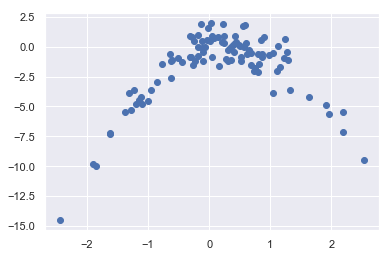

In [370]:
plt.scatter(x,y);

**(c)** Set a random seed, and then compute the LOOCV errors that result from fitting four models using least squares.

**(d),(e),(f)**

>Since our true data is quadratic, the quadratic model has the lowest LOOCV error.

In [371]:
df = pd.DataFrame(np.array([np.ones(len(x)), x, x**2, x**3, x**4, y]).T, \
                 columns=['b0', 'x', 'x2', 'x3', 'x4', 'y'])
df.head()

,b0,x,x2,x3,x4,y
0,1.0,-0.447129,0.199924,-0.089392,0.039970,-1.247855
1,1.0,1.224508,1.499419,1.836050,2.248258,-0.950325
2,1.0,0.403492,0.162806,0.065691,0.026506,-0.484425
3,1.0,0.593579,0.352335,0.209139,0.124140,1.843786
4,1.0,-1.094912,1.198832,-1.312615,1.437198,-4.824527


In [317]:
X = df.iloc[:, :5] # all the rows and the first 5 columns
y = df['y']

errors = np.zeros((len(X), 4))
clf = LinearRegression()
for i in range(len(X)):
    leave_out = ~X.index.isin([i])
    for j in range(4):
        clf.fit(X.iloc[leave_out, :j+2], y[leave_out])
        errors[i,j] = (clf.predict([X.iloc[i, :j+2]]) - y[i]) **2

In [319]:
errors.mean(axis=0)

array([8.29221162, 1.01709581, 1.04655346, 1.05749267])

**9.** We will now consider the Boston housing data set, from the MASS library.

**(a)** Based on this data set, provide an estimate for the population mean of medv. Call this estimate μˆ.

In [374]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv').dropna()
print("Shape of dataframe: " + str(df.shape))
df.head()

Shape of dataframe: (506, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [377]:
df.describe().loc[['mean'],['medv']]

,medv
mean,22.532806


In [378]:
# another way to get mean of 'medv'
df['medv'].mean()

22.532806324110677

**(b)** Provide an estimate of the standard error of μˆ. Interpret this result. _Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations._

In [380]:
df['medv'].std()/(np.sqrt(len(df)))

0.40886114749753505

**(c)** Now estimate the standard error of μˆ using the bootstrap. How does this compare to your answer from (b)?

>Very close to (b). 0.408 vs 0.393

In [403]:
# how to sample 'medv' from df. (uses pd.df.sample)
# can keep running this cell to get more samples
# you can select random_state=(int) to select a seed
df['medv'].sample(n=len(df), replace=True).mean()

22.867786561264822

In [407]:
# bootstrap our sampling from above. let's do it 1000 times
means = [df['medv'].sample(n=len(df), replace=True).mean() for i in range(1000)]
np.std(means)

0.39338181607359535

**(d)** Based on your bootstrap estimate from (c), provide a 95 % confidence interval for the mean of medv. Compare it to the results obtained using t.test(Boston$medv).

_Hint: You can approximate a 95% confidence interval using the formula [μˆ − 2SE(μˆ), μˆ + 2SE(μˆ)]._

In [417]:
mean = np.mean(means)
std = np.std(means)

mean-2*std, mean+2*std

(21.750394075362692, 23.323921339657076)

In [418]:
from scipy import stats

In [431]:
# one sample t-test
stats.ttest_1samp(df['medv'], std)

Ttest_1sampResult(statistic=54.1490054595382, pvalue=1.8902409332198788e-212)

In [429]:
# 95% conf interval
stats.norm.interval(0.95, loc=mean, scale=std)

(21.766143515832677, 23.30817189918709)

**(e)** Based on this data set, provide an estimate, μˆmed, for the median value of medv in the population.

In [433]:
df['medv'].median()

21.2

**(f)** We now would like to estimate the standard error of μˆmed. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

>Small SE for median. 20.9 v 0.38

In [440]:
# similar to (c)
df['medv'].sample(n=len(df), replace=True).median()

20.9

In [441]:
meds = [df['medv'].sample(n=len(df), replace=True).median() for i in range(1000)]
np.std(meds)

0.3875551573647289

**(g)** Based on this data set, provide an estimate for the tenth percentile of medv in Boston suburbs. Call this quantity μˆ0.1. (You can use the quantile() function.)

In [453]:
# use pandas 'quantile' api
df['medv'].quantile(q=0.1)

12.75

**(h)** Use the bootstrap to estimate the standard error of μˆ0.1. Comment on your findings.

Remember: MEDV - Median value of owner-occupied homes in $1000's

>Larger relative SE for the tenth percentile that the whole market. There is more price fluctuation at the bottom end of the market relative to the whole market.

In [445]:
q_1 = [df['medv'].sample(n=len(df), replace=True).quantile(q=0.1) for i in range(1000)]
np.std(q_1)

0.502668814926886

In [450]:
df.describe().loc[:,['medv']]

,medv
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000
